<a href="https://colab.research.google.com/github/pramodkoujalagi/Char-isma/blob/main/Char_isma_Manual_Backprop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
words[:10]

32033
15


['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [4]:
# Building the vocabulary of characters & mappings to the integers and vice-versa
characters = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(characters)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# Block size is nothing but the context length or the number of character I am taking to predict the next character.
block_size = 3

# Building Dataset
def dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      Xi = stoi[ch]
      X.append(context)
      Y.append(Xi)
      context = context[1:] + [Xi] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

X_train,  Y_train  = dataset(words[:n1]) # 80%
X_val, Y_val = dataset(words[n1:n2])     # 10%
X_test,  Y_test  = dataset(words[n2:])   # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
# utility function to be used later for comparison (To compare manual gradients to PyTorch gradients)
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [7]:
n_embd = 10 # The dimensionality of the character embedding vectors
n_hidden = 64 # The number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),          generator=g)

# Layer 1
W1 = torch.randn((n_embd*block_size, n_hidden), generator=g) * (5/3)/((n_embd*block_size)**0.5) # for tanh
b1 = torch.randn(n_hidden,                      generator=g) * 0.1 # it's useless because of Batch Normalization
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),        generator=g) * 0.1
b2 = torch.randn(vocab_size,                    generator=g) * 0.1

# Params for BatchNorm
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1 # initializating many of these parameters in non-standard ways

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

4137


In [8]:
batch_size = 32
m = batch_size

# minibatch
Xi = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
Xb, Yb = X_train[Xi], Y_train[Xi] # batch X,Y

### Forward pass

In [9]:
# Created smaller chunks that are possible to backward one at a time

emb = C[Xb] # embedding the characters into vectors
emb_cat = emb.view(emb.shape[0], -1) # concatenate the vectors
# Linear layer 1
hpre_bn = emb_cat @ W1 + b1 # hidden layer pre-activation

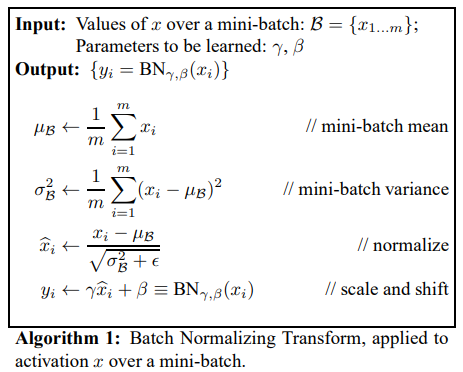

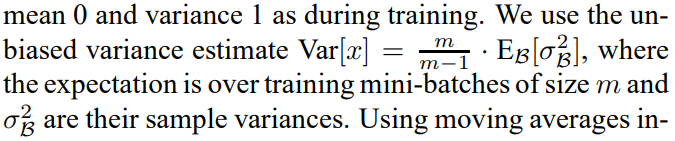

* During inference in the paper they are using unbiased varience i.e (m-1) instead of m (biased)

* More about Bessel's correction: https://mathcenter.oxford.emory.edu/site/math117/besselCorrection/

In [10]:
# BatchNorm layer as in above paper
bnmeani = 1/m*hpre_bn.sum(0, keepdim=True)
bndiff = hpre_bn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(m-1)*(bndiff2).sum(0, keepdim=True) # Bessel's correction (dividing by m-1, not m)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias

# Non-linearity
h = torch.tanh(hpreact) # hidden layer

# Linear layer 2
logits = h @ W2 + b2 # output layer

# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # can't backprop if (1.0/counts_sum) is used
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(m), Yb].mean()

# Backward pass (PyTorch)
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hpre_bn, bnmeani, emb_cat, emb]:
  t.retain_grad()
loss.backward()
loss

tensor(3.3666, grad_fn=<NegBackward0>)

In [11]:
logits.shape, logit_maxes.shape, norm_logits.shape

(torch.Size([32, 27]), torch.Size([32, 1]), torch.Size([32, 27]))

In [12]:
hpre_bn.shape, bnmeani.shape

(torch.Size([32, 64]), torch.Size([1, 64]))

In [13]:
emb_cat.shape, emb.view(emb.shape[0], -1).shape, emb.shape

(torch.Size([32, 30]), torch.Size([32, 30]), torch.Size([32, 3, 10]))

In [14]:
"""
backpropagating through the whole thing manually,
backpropagating through exactly all of the variables
as they are defined in the forward pass above, one by one
"""

dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(m), Yb] = -1.0/m

dprobs = (1.0/probs) * dlogprobs

dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)
dcounts = counts_sum_inv * dprobs

dcounts_sum = -counts_sum**-2 * dcounts_sum_inv
dcounts += torch.ones_like(counts) * dcounts_sum

dnorm_logits = counts * dcounts # counts = norm_logits.exp()

dlogits = dnorm_logits.clone()
dlogit_maxes = (-dnorm_logits).sum(1, keepdim=True)


dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes # Even this worked for me: dlogit_maxes + dlogits

dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(0)

dhpreact = (1.0 - h**2) * dh

dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
dbnbias = dhpreact.sum(0, keepdim=True)
dbnraw = bngain * dhpreact
dbndiff = bnvar_inv * dbnraw
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
dbnvar = (-0.5 * (bnvar + 1e-5) ** (-1.5)) * dbnvar_inv
dbndiff2 = (1.0/(m-1))*torch.ones_like(bndiff2) * dbnvar
dbndiff +=  (2*bndiff) * dbndiff2
dhpre_bn = dbndiff.clone()
dbnmeani = -dbndiff.sum(0)
dhpre_bn += 1.0/m *torch.ones_like(hpre_bn) * dbnmeani

demb_cat = dhpre_bn @ W1.T
dW1 = emb_cat.T @ dhpre_bn
db1 = dhpre_bn.sum(0)

demb = demb_cat.view(emb.shape)
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
  for j in range(Xb.shape[1]):
    ix = Xb[k,j]
    dC[ix] += demb[k,j]

cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hpre_bn', dhpre_bn, hpre_bn)
cmp('emb_cat', demb_cat, emb_cat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10
bngain          | exact: False | approximate: True  | maxdiff: 1.862645149230957e-09
bnbias          | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09
bnraw   

In [15]:
# backward pass

dlogits = F.softmax(logits, 1)
dlogits[range(m), Yb] -=1
dlogits /=m

cmp('logits', dlogits, logits)

logits          | exact: False | approximate: True  | maxdiff: 4.190951585769653e-09


In [16]:
dhpre_bn = bngain * bnvar_inv/m * (m*dhpreact - dhpreact.sum(0) - m/(m-1)*bnraw*(dhpreact*bnraw).sum(0))

cmp('hpre_bn', dhpre_bn, hpre_bn)

hpre_bn         | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


In [19]:
# Training the MLP neural net with my own backward pass

n_embd = 10 # Dimensionality of the character embedding vectors
n_hidden = 200 # Number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # For reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)

# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1

# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1

# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

max_steps = 200000
batch_size = 32
m = batch_size # small variable is convenient to use :)
lossi = []

#with torch.no_grad():

for i in range(max_steps):

  # minibatch construct
  Xi = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
  Xb, Yb = X_train[Xi], Y_train[Xi] # batch X,Y

  # forward pass
  emb = C[Xb] # embedding the characters into vectors
  emb_cat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpre_bn = emb_cat @ W1 + b1 # hidden layer pre-activation

  # BatchNorm layer
  bnmean = hpre_bn.mean(0, keepdim=True)
  bnvar = hpre_bn.var(0, keepdim=True, unbiased=True)
  bnvar_inv = (bnvar + 1e-5)**-0.5
  bnraw = (hpre_bn - bnmean) * bnvar_inv
  hpreact = bngain * bnraw + bnbias

  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  # loss.backward() # commenting to use manual bckprop!

  # manual backprop!
  # pasting the above derived manual backprop cells
  dlogits = F.softmax(logits, 1)
  dlogits[range(m), Yb] -= 1
  dlogits /= m
  # 2nd layer backprop
  dh = dlogits @ W2.T
  dW2 = h.T @ dlogits
  db2 = dlogits.sum(0)
  # tanh
  dhpreact = (1.0 - h**2) * dh
  # batchnorm backprop
  dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
  dbnbias = dhpreact.sum(0, keepdim=True)
  dhpre_bn = bngain*bnvar_inv/m * (m*dhpreact - dhpreact.sum(0) - m/(m-1)*bnraw*(dhpreact*bnraw).sum(0))
  # 1st layer
  demb_cat = dhpre_bn @ W1.T
  dW1 = emb_cat.T @ dhpre_bn
  db1 = dhpre_bn.sum(0)
  # embedding
  demb = demb_cat.view(emb.shape)
  dC = torch.zeros_like(C)
  for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
      Xi = Xb[k,j]
      dC[Xi] += demb[k,j]
  grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p, grad in zip(parameters, grads):
    p.data += -lr * grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

12297
      0/ 200000: 3.8025
  10000/ 200000: 2.1688
  20000/ 200000: 2.4046
  30000/ 200000: 2.4507
  40000/ 200000: 2.0039
  50000/ 200000: 2.3857
  60000/ 200000: 2.3877
  70000/ 200000: 2.0984
  80000/ 200000: 2.3636
  90000/ 200000: 2.1809
 100000/ 200000: 1.9249
 110000/ 200000: 2.3234
 120000/ 200000: 2.0108
 130000/ 200000: 2.4664
 140000/ 200000: 2.3637
 150000/ 200000: 2.1127
 160000/ 200000: 1.9466
 170000/ 200000: 1.8365
 180000/ 200000: 1.9716
 190000/ 200000: 1.8703


In [20]:
with torch.no_grad():
  emb = C[X_train]
  emb_cat = emb.view(emb.shape[0], -1)
  hpreact = emb_cat @ W1 + b1
  # measuring the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnvar = hpreact.var(0, keepdim=True, unbiased=True)

In [21]:
@torch.no_grad() # disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (X_train, Y_train),
    'val': (X_val, Y_val),
    'test': (X_test, Y_test),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  emb_cat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = emb_cat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0708084106445312
val 2.111037254333496


In [22]:
# sample from the model
g = torch.Generator()

for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
      # forward passing the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      emb_cat = emb.view(emb.shape[0], -1)
      hpreact = emb_cat @ W1 + b1
      hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
      h = torch.tanh(hpreact) # (N, n_hidden)
      logits = h @ W2 + b2 # (N, vocab_size)
      probs = F.softmax(logits, dim=1)

      # sample from the distribution
      Xi = torch.multinomial(probs, num_samples=1, generator=g).item()

      # shift the context window and track the samples
      context = context[1:] + [Xi]
      out.append(Xi)

      # if the special token '.', then break
      if Xi == 0:
        break
    print(''.join(itos[i] for i in out)) # decoding and printing the generated word

cynia.
emili.
hyn.
yea.
tylia.
ier.
dimrayie.
maisyn.
stani.
aadlom.
marber.
liann.
grachi.
sanibray.
bleianey.
evaanisha.
mohana.
jayva.
brayla.
amana.


In [23]:
# sample from the model
g = torch.Generator().manual_seed(42)

for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
      # forward passing the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      emb_cat = emb.view(emb.shape[0], -1)
      hpreact = emb_cat @ W1 + b1
      hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
      h = torch.tanh(hpreact) # (N, n_hidden)
      logits = h @ W2 + b2 # (N, vocab_size)
      probs = F.softmax(logits, dim=1)

      # sample from the distribution
      Xi = torch.multinomial(probs, num_samples=1, generator=g).item()

      # shift the context window and track the samples
      context = context[1:] + [Xi]
      out.append(Xi)

      # if the special token '.', then break
      if Xi == 0:
        break
    print(''.join(itos[i] for i in out)) # decoding and printing the generated word

yansy.
theolan.
dlee.
khalei.
jyannayah.
arhen.
ena.
daya.
jiah.
abdeles.
lou.
topheevani.
pepollyn.
zakelsen.
lam.
shina.
luna.
adari.
zerianne.
nehilsemale.
